In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
sns.set()

## Simple model


$$x \sim \mathcal{N}(x|\mu, 1)$$

$$y \sim \mathcal{N}(y|x, 1)$$

#### Problem statement

Recover $p(y|\mu)$ with differentable neural network and be able to make gradient step of some statistic from 

$$r = R\left( \{ y_i \}_{i=0}^{B} \right)$$, 

i.e. be able to calculate:

$$\frac{\partial r}{\partial \mu} = ?$$.

## Make model with `pyro`

In [2]:
mu_dist = dist.Delta(torch.tensor(-50., requires_grad=True))

In [3]:
def f(x):
    return x.sin() + x.tanh()

#@pyro.condition(data={"x": torch.tensor(1.)})
def y_sample():
    mu = pyro.sample('mu', mu_dist)
    x = pyro.sample("x", dist.Normal(mu, 1))
    x = f(x)
    return pyro.sample("y", dist.Normal(x, 1))

## Statistic of interest

$$r = \frac{1}{N} \sum\limits_{i=0}^{N} || y_i - Y ||_2^2$$

In [4]:
def R(ys: torch.tensor, Y_0=-5):
    return (ys - Y_0).pow(2).mean()

## Approaches to solve the problem

### First one

  1. Make approximation of this model:

  $$p(y | \mu)$$

  With GANs or some other techniques.
  

  2. Sample $\{ y_i \}_{i=0}^{B} \sim p(y | \mu)$
  
  
  3. Calc $r = R(\{ y_i \}_{i=0}^{B})$
  
  
  4. Find $\frac{\partial r}{\partial \mu}$
  
### Second one


  1. Make approximation of this model:

  $$p(r | \mu)$$
  
  
  2. Sample $r \sim p(r | \mu)$
  
  
  3. Find $\frac{\partial r}{\partial \mu}$

## Investigation of the model

In [5]:
samples = torch.stack([y_sample() for _ in range(1000)])

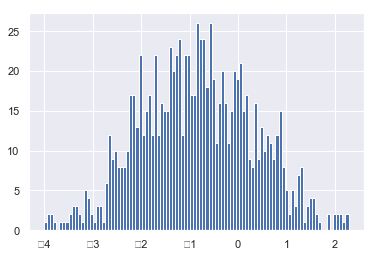

In [6]:
plt.hist(samples.detach().cpu().numpy(), bins=100);

In [7]:
R(samples).item()

18.617748260498047

#### Simple way to change `mu`

In [8]:
conditioned_y_sample = poutine.condition(y_sample, data={"mu": torch.tensor(-2.)})

In [9]:
samples = torch.stack([conditioned_y_sample() for _ in range(1000)])

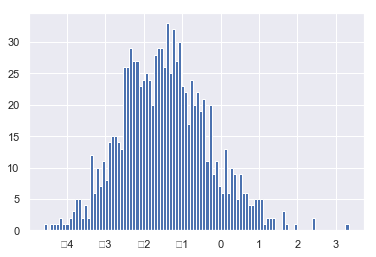

In [10]:
plt.hist(samples.detach().cpu().numpy(), bins=100);

In [11]:
import numpy as np

rs = []
mus = np.linspace(-100, 100, 100)
for mu in tqdm.tqdm(mus):
    conditioned_y_sample = poutine.condition(y_sample, data={"mu": torch.tensor(mu)})
    samples = torch.stack([conditioned_y_sample() for _ in range(1000)])
    rs.append(R(samples).item())

100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


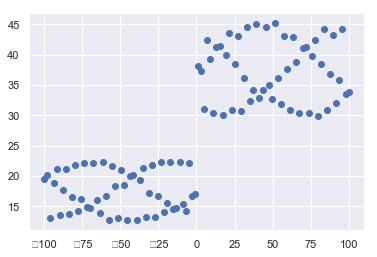

In [12]:
plt.scatter(mus, rs)